In [27]:
# Celda 1: Imports, parámetros y configuración de la semilla ───────────────────────────────────────

import numpy as np                      # Celdas: 2,3,4,5,6,7,8 (NP arrays, random choice with rng)
import matplotlib.pyplot as plt         # Celdas: 2,6,7,8 (Visualización, gráficos, animación)
import time                             # Celda: 5 (Medición de tiempos)
from tqdm import tqdm                   # Celda: 5 (Barra de progreso, opcional)
import argparse                         # Celdas: 1 (parseo de argumentos)
import sys                              # Para obtener argv en parse_known_args
from numba import njit, set_num_threads, get_num_threads, prange
import os                               # Para obtener el número de hilos disponibles
import h5py  # Para guardar resultados en formato HDF5
import subprocess, threading, re, math # Última celda para la generación del video

# ─── Parámetros del modelo ────────────────────────────────────────────────────
L        = int(32)                      #(int)
J        = float(1.0)                   #(float) 
T        = float(1.0)                    #(float)
Beta     = 1.0 / T                       #(float) Inverso de la temperatura
n_sweeps = int(1500000)                     #(int)
threads_percentage = int(100)           #(int) Porcentaje de hilos a usar (100% = todos los disponibles)

# ─── Configuración de semilla para reproducibilidad ──────────────────────────
seed = None                             # None = usar entropía del sistema
rng  = np.random.default_rng(seed)      # PCG64 RNG: seguro y adecuado para simulaciones

#Establecemos el número de hilos a usar asegurándonos de que no exceda el número de hilos disponibles ni sea menor a 1
n_threads_available = os.cpu_count()
if n_threads_available is None:
    n_threads_available = 1  # Si no se puede determinar, usar al menos 1 hilo
threads_percentage = max(1, min(100, threads_percentage))
set_num_threads(int(n_threads_available*(threads_percentage / 100.0)))
n_threads = get_num_threads()
print(f"Usando {n_threads} hilos de {n_threads_available} disponibles ({threads_percentage}%).")

Usando 16 hilos de 16 disponibles (100%).


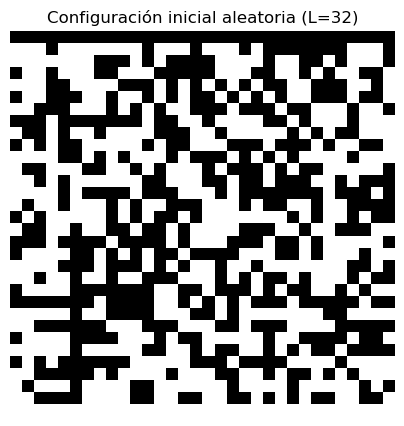

In [28]:
# ─── Celda 2: Inicialización de la red y visualización ───────────────────────
# Generar configuración inicial aleatoria de espines ±1
def init_config(L, rng):
    """
    Crea una matriz LxL de espines aleatorios ±1 usando el RNG proporcionado.
    """
    return rng.choice([1, -1], size=(L, L))

# Forzar que la fila de arriba sea negativa y la de abajo positiva
def force_boundary_conditions(config):
    """
    Fuerza las condiciones de frontera: fila superior -1, fila inferior +1.
    """
    config[0, :] = -1  # Fila superior
    config[L-1, :] = 1  # Fila inferior
    return config

# Crear configuración y mostrarla
config = force_boundary_conditions(init_config(L, rng))
plt.figure(figsize=(5,5))
plt.imshow(force_boundary_conditions(init_config(L, rng)), cmap='gray', interpolation='nearest')
plt.title(f'Configuración inicial aleatoria (L={L})')
plt.axis('off')
plt.show()

In [29]:
# ─── Celda 3: Definición de observables termodinámicos ─────────────────────
@njit(parallel=True)
def energy(config, J, L):
    """
    Calcula la energía total del modelo de Ising 2D con contorno periódico.
    """
    # Enlaces derecha e inferior para contar cada par una sola vez
    sum = 0.0
    for i in prange(L):
        for j in range(L):
            sum += config[i, j] * (config[i, (j + 1) % L] + config[(i + 1) % L, j])

    return -J * sum

@njit(parallel=True)
def magnetization(config, L):
    """
    Calcula la magnetización total del sistema.
    """
    sum = 0.0
    for i in prange(L):
        for j in range(L):
            sum += config[i, j]
    return sum

# Ejemplo de uso en Celda 3
E0 = energy(config, J, L)
M0 = magnetization(config, L)
print(f"Energía inicial: {E0:.2f}, Magnetización inicial: {M0}")

Energía inicial: -12.00, Magnetización inicial: 14.0


In [30]:
def calculate_acceptance(frames: np.ndarray) -> np.ndarray:
    
    nframes, H, W = frames.shape
    # `True` donde el espín cambió respecto al sweep anterior
    changes = frames[1:] != frames[:-1]               # shape (nframes-1, H, W)
    diff_counts = changes.reshape(nframes-1, -1).sum(axis=1)
    # Cada swap válido intercambia dos posiciones
    accepted_swaps = diff_counts / 2
    # Nº de intentos de swap por sweep ≈ H*W
    attempts = H * W
    acceptance = accepted_swaps / attempts
    return acceptance


@njit
def delta_E_kawasaki(config, i, j, k, l, J):
    """
    Calcula el cambio de energía ΔE para un intercambio de espines en la dinámica de Kawasaki.
    """
    delta_E = 0.0
    E_1 = 0.0
    E_2 = 0.0
    neighbors_ij = 0.0
    neighbors_kl = 0.0
    neighbors_ij = config[i,(j-1)%L] + config[(i-1)%L,j] + config[(i+1)%L,j] + config[i,(j+1)%L] - config[k, l]
    neighbors_kl = config[k,(l-1)%L] + config[(k-1)%L,l] + config[(k+1)%L,l] + config[k,(l+1)%L] - config[i, j]
    #Calculamos la energía de la configuración inicial
    E_1 = config[i,j]*neighbors_ij+config[k,l]*neighbors_kl
    #Calculamos la energía de la configuración final
    E_2 = config[k,l]*neighbors_ij+config[i,j]*neighbors_kl
    #Calculamos el cambio de energía
    delta_E = -J*(E_2 - E_1)
    return delta_E


#Paso de la simulación
@njit
def sweep_kawasaki(config, L, J, Beta):
    for k in range(((L-2)*L)):
        #Seleccionamos un espín aleatorio (i, j) de la red excluyendo las filas superior e inferior
        i, j = np.random.randint(1, L-1), np.random.randint(0, L)
        # Escribimos el espin seleccionado en un archivo para depuración
        # Definimos los offsets para los vecinos (arriba, abajo, izquierda, derecha)
        offsets = np.array([(1, 0), (0, 1), (0, -1),  (-1, 0)], dtype=np.int64)
        # Ahora seleccionamos un offset aleatorio que decidirá si escogemos un vecino arriba, abajo, izquierda o derecha
        #Hay que mantener la condición de los espines superior e inferior.
        # Entonces lo que hacemos es limitar los offsets a 3 si estamos en la fila superior o inferior, y a 4 si estamos en el resto de la red.
        # Y luego forzamos que si está en la fila
        if i == 1:
            di, dj = offsets[np.random.randint(0, 3)]
        elif i == L-2:
            di, dj = offsets[np.random.randint(1, 4)]
        else:
            di, dj = offsets[np.random.randint(0, 4)]
        # Ahora podemos calcular la posición exacta del espín vecino
        ni, nj = (i + di) % L, (j + dj) % L
        # Escribimos el espín vecino en el archivo para depuración
        # Ahora que tenemos la posición del espín vecino, comprobamos que no sea el mismo espín (i, j) que el vecino (ni, nj)
        if config[i, j] != config[ni, nj]:
            delta_E = delta_E_kawasaki(config, i, j, ni, nj, J)
            # Ahora que tenemos el ΔE, podemos decidir si aceptamos o no el movimiento
            # La condición básicamente es que para ΔE <= 0, aceptamos el movimiento, ya que de ser así la probabilidad de aceptación es 1.
            # Si ΔE > 0, aceptamos el movimiento con probabilidad p = exp(-ΔE/T), y lo más eficiente es generar un número aleatorio entre 0 y 1 y comparar con p,
            # ya que si el número aleatorio es menor o igual que p, aceptamos el movimiento.
            if delta_E <= 0 or np.random.rand() < np.exp(-delta_E * Beta):
                    # Intercambiar espines
                    config[i, j], config[ni, nj] = config[ni, nj], config[i, j]
        

MC Sweeps:   0%|          | 0/1500000 [00:00<?, ?it/s]

MC Sweeps: 100%|██████████| 1500000/1500000 [06:29<00:00, 3855.70it/s]


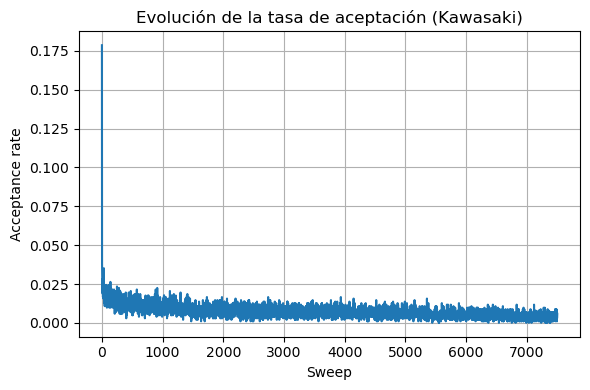

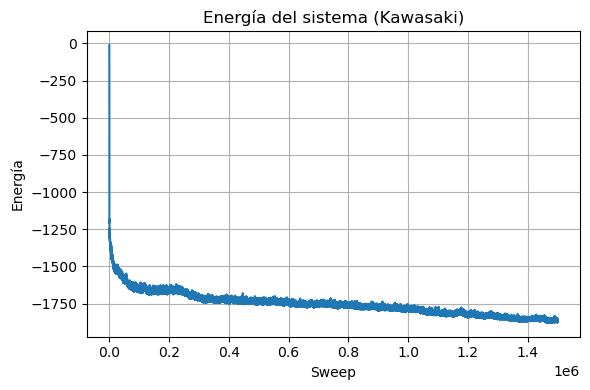

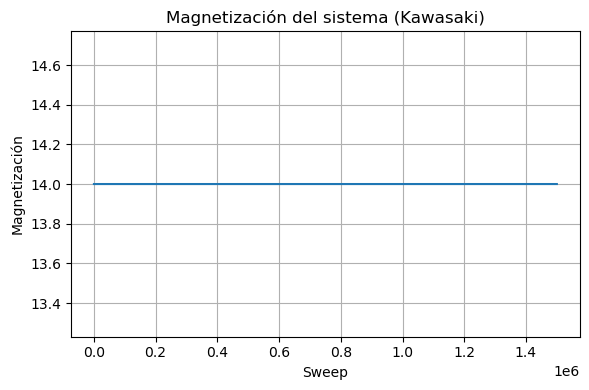

Simulación completada en 389.0341 s


In [31]:
# ─── Celda 5: Bucle Monte Carlo y recolección de datos con HDF5 ────────────
# Inicializar arrays para almacenar energía y magnetización
energies = np.zeros(n_sweeps + 1)
magnetizations = np.zeros(n_sweeps + 1)

# Parámetros de guardado
thin = 200        # guardar cada ‘thin’ sweeps (ajusta a 1 si quieres todos)
n_saved = (n_sweeps // thin) + 1

# Prepara el fichero HDF5 y mantenlo abierto durante toda la simulación
destino = 'configs.h5'
with h5py.File(destino, 'w') as f:
    # Dataset para las configuraciones: snapshots × L × L, dtype int8
    ds = f.create_dataset(
        'configs',
        shape=(n_saved, L, L),
        dtype='i1',
        compression='gzip',
        compression_opts=4,
        chunks=(1, L, L),
    )
    # Metadatos
    f.attrs['J'] = J
    f.attrs['T'] = T
    f.attrs['L'] = L
    f.attrs['n_sweeps'] = n_sweeps
    f.attrs['thin'] = thin

    # Medir estado inicial
    energies[0] = energy(config, J, L)
    magnetizations[0] = magnetization(config, L)
    # Guardar configuración inicial ds[0]
    ds[0, :, :] = config

    # Barrido Monte Carlo
    start_time = time.time()
    idx = 1  # índice para guardar snapshots
    for sweep in tqdm(range(1, n_sweeps + 1), desc='MC Sweeps'):  # Esto es una simple barra de progreso, nada más
        # Ahora calculamos las coordenadas de los espines a intercambiar mediante un vector de offsets
        offsets = np.array([(0, 1), (0, -1), (1, 0), (-1, 0)], dtype=np.int64)  # Al sumar el offset a la posición del espín, obtenemos la posición del espín vecino.
        # Ahora podemos barrer la red para elegir el par de espines a intercambiar.
        sweep_kawasaki(config, L, J, T)
        # Registrar observables
        energies[sweep] = energy(config, J, L)
        magnetizations[sweep] = magnetization(config, L)
        

        # Almacenar las configuraciones “thinned” si toca
        if sweep % thin == 0:
            ds[idx, :, :] = config
            idx += 1

    end_time = time.time()

# Plotear los datos importantes

# ─── Acceptance rate ────────────────────────────────

# 1) Cargar todos los frames desde el HDF5
with h5py.File('configs.h5', 'r') as f:
    frames = f['configs'][:]    # np.ndarray (nframes, H, W)

# 2) Calcular la aceptación
acceptance = calculate_acceptance(frames)

# 3) Representar la evolución de la tasa de aceptación
sweeps = np.arange(1, len(acceptance) + 1)
plt.figure(figsize=(6, 4))
plt.plot(sweeps, acceptance, linestyle='-')
plt.xlabel('Sweep')
plt.ylabel('Acceptance rate')
plt.title('Evolución de la tasa de aceptación (Kawasaki)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ─── Energía ────────────────────────────────

n_sweeps_array = np.arange(n_sweeps + 1)

plt.figure(figsize=(6, 4))
plt.plot(n_sweeps_array, energies, linestyle='-')
plt.xlabel('Sweep')
plt.ylabel('Energía')
plt.title('Energía del sistema (Kawasaki)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ─── Magnetización ────────────────────────────────

plt.figure(figsize=(6, 4))
plt.plot(n_sweeps_array, magnetizations, linestyle='-')
plt.xlabel('Sweep')
plt.ylabel('Magnetización')
plt.title('Magnetización del sistema (Kawasaki)')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Simulación completada en {end_time - start_time:.4f} s")

In [32]:
# Celda: pipeline GPU-BOUND con NVENC a partir de HDF5

# ── Parámetros de usuario ─────────────────────────────────────────────────────
HDF5_FILE = "configs.h5"
DATASET   = "configs"
FILE_OUT  = "simulacion"
GPU_ID    = 0           # 0 = tu NVIDIA 4050
INTERVAL  = 125          # ms entre frames → fps = 1000/INTERVAL
TARGET_W  = 1000        # ancho deseado; None para mantener original
TARGET_H  = None        # alto deseado; None para mantener original
MIN_SIDE  = 160         # mínimo seguro para NVENC (≥ 145 y par)
# ──────────────────────────────────────────────────────────────────────────────

# 1) Cargar datos --------------------------------------------------------------
with h5py.File(HDF5_FILE, 'r') as f:
    frames = f[DATASET][:]
nframes, h0, w0 = frames.shape
fps = 1000.0 / INTERVAL
print(f"→ {nframes} frames ({w0}×{h0}px) @ {fps:.1f} fps")

# 2) Calcular resolución de salida --------------------------------------------
w_out, h_out = w0, h0
if TARGET_W and not TARGET_H:
    scale = TARGET_W / w0
    w_out = TARGET_W
    h_out = int(round(h0 * scale))
elif TARGET_H and not TARGET_W:
    scale = TARGET_H / h0
    h_out = TARGET_H
    w_out = int(round(w0 * scale))
elif TARGET_W and TARGET_H:
    w_out, h_out = TARGET_W, TARGET_H

# Asegurar mínimo NVENC
if min(w_out, h_out) < MIN_SIDE:
    factor = math.ceil(MIN_SIDE / min(w_out, h_out))
    w_out *= factor
    h_out *= factor
    print(f"⚠️ Redimensionado extra para mínimo NVENC ({MIN_SIDE}px)")

# Redondear a par
w_out = (w_out // 2) * 2
h_out = (h_out // 2) * 2
if (w_out, h_out) != (w0, h0):
    print(f"🔧 Escalando: {w0}×{h0} → {w_out}×{h_out}")
vf_filter = ["-vf", f"scale={w_out}:{h_out}:flags=neighbor"] if (w_out, h_out) != (w0, h0) else []

# 3) Detectar NVENC ------------------------------------------------------------
encoders = subprocess.run(
    ["ffmpeg", "-hide_banner", "-encoders"],
    capture_output=True, text=True
).stdout
if "h264_nvenc" in encoders:
    print("✅ h264_nvenc detectado → GPU")
    video_opts = [
        "-c:v", "h264_nvenc", "-gpu", str(GPU_ID),
        "-preset", "p1", "-profile:v", "high444p", "-pix_fmt", "yuv444p"
    ]
else:
    print("⚠️ NVENC no disponible → libx264 (CPU)")
    video_opts = ["-c:v", "libx264", "-preset", "veryslow", "-crf", "0", "-pix_fmt", "yuv420p"]

# 4) Comando FFmpeg ------------------------------------------------------------
cmd = (
    ["ffmpeg", "-y",
     "-f", "rawvideo", "-pix_fmt", "rgb24",
     "-s", f"{w0}x{h0}", "-r", str(fps), "-i", "-",
     "-progress", "pipe:1", "-loglevel", "error"]
    + vf_filter + video_opts + [f"{FILE_OUT}.mp4"]
)
print("FFmpeg:", " ".join(cmd))

# 5) Lanzar FFmpeg -------------------------------------------------------------
proc = subprocess.Popen(
    cmd,
    stdin = subprocess.PIPE,
    stdout = subprocess.PIPE,
    stderr = subprocess.PIPE,
    bufsize = 0
)

# 6) Barra de codificación -----------------------------------------------------
pbar_enc = tqdm(total=nframes, desc="🛠️ Codificando", unit="frame")
def _watch():
    re_time = re.compile(rb"out_time_ms=(\d+)")
    re_fr   = re.compile(rb"frame=(\d+)")
    while True:
        line = proc.stdout.readline()
        if not line:
            break
        m = re_fr.search(line) or re_time.search(line)
        if m:
            val = int(m.group(1))
            done = val if b"frame" in line else min(nframes, int(round(val * fps / 1000)))
            pbar_enc.n = done
            pbar_enc.refresh()

threading.Thread(target=_watch, daemon=True).start()

# 7) Enviar frames -------------------------------------------------------------
with tqdm(total=nframes, desc="📤 Enviando frames", unit="frame") as pbar_in:
    for frame in frames:
        # Convertir de Ising (-1,+1) a [0,255] y a RGB
        rgb = np.repeat(((frame + 1) * 127.5).astype(np.uint8)[..., None], 3, axis=2)
        proc.stdin.write(rgb.tobytes())
        pbar_in.update(1)

proc.stdin.close()
proc.wait()
pbar_enc.n = nframes
pbar_enc.refresh()
pbar_enc.close()

print(f"🎉 Vídeo generado: {FILE_OUT}.mp4 ({w_out}×{h_out})")


→ 7501 frames (32×32px) @ 8.0 fps
🔧 Escalando: 32×32 → 1000×1000
✅ h264_nvenc detectado → GPU
FFmpeg: ffmpeg -y -f rawvideo -pix_fmt rgb24 -s 32x32 -r 8.0 -i - -progress pipe:1 -loglevel error -vf scale=1000:1000:flags=neighbor -c:v h264_nvenc -gpu 0 -preset p1 -profile:v high444p -pix_fmt yuv444p simulacion.mp4


🛠️ Codificando: 100%|██████████| 7501/7501 [00:06<00:00, 1128.99frame/s]

🎉 Vídeo generado: simulacion.mp4 (1000×1000)
